   ## Inference v1 - Sliding Window
   ### VGG16 
   ### Training last conv block - fc1 (4096) fc2(4096) softmax

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
from keras.models import model_from_json
from keras import optimizers
import os

from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, load_img

Using TensorFlow backend.


In [2]:
from os import listdir
from os.path import isfile, join

filename="1028"

scenefile=join('/part/data/upairdrone/upairtag/',filename+'.jpg')
anno_file=join('/part/data/upairdrone/labels/',filename+'.xml')

if not os.path.exists(scenefile):
    print("No filename ",scenefile," exists.")
else:
    if not os.path.exists(anno_file):
        print("No filename ",anno_file," exists.")
    else:
        print("Filename and Annotation found.")

Filename and Annotation found.


In [3]:
model_json="all_last3_v3.0_arch.json"
model_weight="all_last3_v3.0weights.h5"

small_scale_validation=False

### Open saved model

In [4]:
# Model reconstruction from JSON file
with open(model_json, 'r') as f:
    model = model_from_json(f.read())

model.load_weights(model_weight)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])


## Perform a small scale validation

Only needed when looking at new models

In [5]:
if small_scale_validation==True:
    directory="/repo/copygdrive/data/small/"
    validation_datagen = ImageDataGenerator(rescale=1./255)
    image_size=224
    val_batchsize = 20

    # Create a generator for prediction
    validation_generator = validation_datagen.flow_from_directory(
            directory,
            target_size=(image_size, image_size),
            batch_size=val_batchsize,
            class_mode='categorical',
            shuffle=False)
        # Get the ground truth from generator
    ground_truth = validation_generator.classes

    # Get the label to class mapping from the generator
    label2index = validation_generator.class_indices

    idx2label = dict((v,k) for k,v in label2index.items())
    
    predictions = model.predict_generator(validation_generator,
                                          steps=validation_generator.samples/validation_generator.batch_size,
                                          verbose=1)
    predicted_classes = np.argmax(predictions,axis=1)
    np.where(predicted_classes!=ground_truth)
    ground_truth[np.where(predicted_classes!=ground_truth)]

In [6]:
if small_scale_validation==True:
    directory="/repo/copygdrive/data/small/plastic/"
    onlyfiles = [f for f in listdir(directory) if isfile(join(directory, f))]
    
    # load the image
    print(directory+onlyfiles[0])
    image = cv2.imread(directory+onlyfiles[0])
    plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    orig = image.copy()
    
    # pre-process the image for classification
    image = cv2.resize(image, (image_size, image_size))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    # classify the input image
    (noplastic, plastic) = model.predict(image)[0]
    print("Probability No Plastic",noplastic,"\nProbability Plastic",plastic)

In [7]:
if small_scale_validation==True:
    directory="/repo/copygdrive/data/small/noplastic/"
    onlyfiles = [f for f in listdir(directory) if isfile(join(directory, f))]
    
    # load the image
    print(directory+onlyfiles[0])
    image = cv2.imread(directory+onlyfiles[0])
    plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    orig = image.copy()
    
    # pre-process the image for classification
    image = cv2.resize(image, (image_size, image_size))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    # classify the input image
    print(model.predict(image)[0][1]>0.9)
    print("Probability No Plastic",noplastic,"\nProbability Plastic",plastic)

### Show Example Image

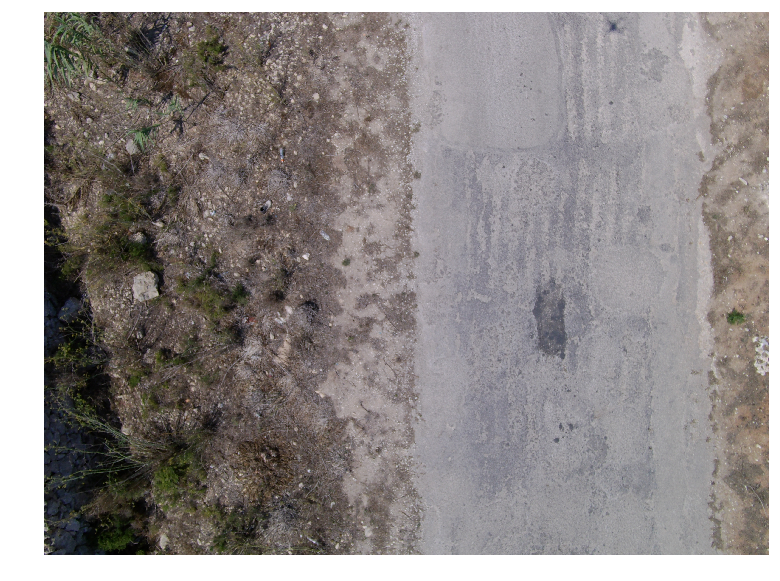

In [8]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

image = cv2.imread(scenefile)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(image)
plt.show()

## Small Object Detection Using Sliding Window
### Tile image in 224x224 using 112x112 stride
### Detect each tile

In [9]:
%%time
h,w,c=image.shape
detectmap = np.zeros((29,40))
image_size=224
nx=0
for x in range(0,w-224,112):
    ny=0
    for y in range(0,h-224,112):
        crop_image=image[y:y+image_size,x:x+image_size]
        crop_image = crop_image.astype("float") / 255.0
        img = img_to_array(crop_image)
        img = np.expand_dims(img, axis=0)
        
        detectmap[ny][nx]= model.predict(img)[0][1]
        print(nx,ny,end="    \r")
        ny=ny+1
    nx=nx+1
print(ny,nx)

29 40    
CPU times: user 46min, sys: 44.4 s, total: 46min 45s
Wall time: 12min 51s


Crudely create box on every tile which has plastic detected with probability > 0.99

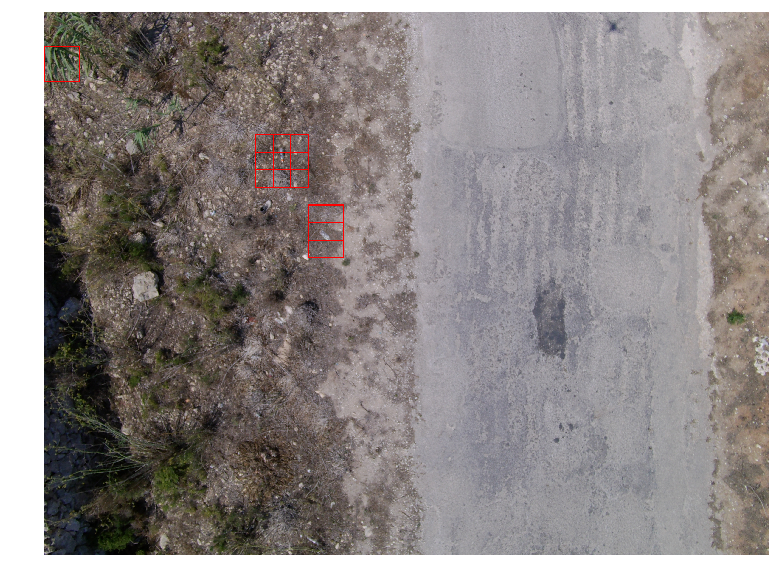

In [10]:
boximage=np.copy(image)
for x in range(nx):
    for y in range(ny):
        if detectmap[y][x]>0.99:
            cv2.rectangle(boximage,(x*112,y*112),(x*112+224,y*112+224),(255,0,0),6)


figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.axis("off")
plt.imshow(boximage)
plt.show()

# Show  Bounding Box
Intersection of detection boxes

In [11]:
boximage=np.copy(image)
deskmask=np.zeros((30,41))

## Bounding box found mapped
for x in range(nx):
    for y in range(ny):
        if detectmap[y][x]>0.99:
            #cv2.rectangle(boximage,(x*112,y*112),(x*112+224,y*112+224),(0,255,0),4)
            deskmask[y  ][x  ]=deskmask[y  ][x  ]+1
            deskmask[y+1][x  ]=deskmask[y+1][x  ]+1
            deskmask[y  ][x+1]=deskmask[y  ][x+1]+1
            deskmask[y+1][x+1]=deskmask[y+1][x+1]+1
            
## Reduce bounding box to only Intersection of neighboring Bounding boxes
for x in range(nx+1):
    for y in range(ny+1):
        x0=x-1
        x1=x+1
        y0=y-1
        y1=y+1
        
        if x==0:
            x0=x
        if x==nx:
            x1=x
        if y==0:
            y0=y
        if y==ny:
            y1=y
        
        if deskmask[y][x]!=max(deskmask[y0][x0],
                               deskmask[y0][x ],
                               deskmask[y0][x1],
                               deskmask[y ][x0],
                               deskmask[y ][x ],
                               deskmask[y ][x1],
                               deskmask[y1][x0],
                               deskmask[y1][x ],
                               deskmask[y1][x1]):
            deskmask[y][x]=0
            
boundingbox=[]
for x in range(nx+1):
    for y in range(ny+1):
        if deskmask[y][x]>0:

            x0=x*112
            y0=y*112
            x1=x*112+112
            y1=y*112+112
            
            bx0=-1
            by0=-1
            bx1=-1
            by1=-1
            
            if x>0:
                if deskmask[y][x-1]==0:
                    cv2.line(boximage,(x0,y0),(x0,y1),(255,0,0),6)
                    bx0=x0
            else:
                cv2.line(boximage,(x0,y0),(x0,y1),(255,0,0),6)
                bx0=x0
 
            if y>0:
                if deskmask[y-1][x]==0:
                    cv2.line(boximage,(x0,y0),(x1,y0),(255,0,0),6)
                    by0=y0
            else:
                cv2.line(boximage,(x0,y0),(x1,y0),(255,0,0),6)
                by0=y0

            if x<nx:
                if deskmask[y][x+1]==0:
                    cv2.line(boximage,(x1,y0),(x1,y1),(255,0,0),6)
                    bx1=x1
                else:
                    bx1=x1+112
            else:
                cv2.line(boximage,(x1,y0),(x1,y1),(255,0,0),16)
                bx1=x1
            
            if y<ny:
                if deskmask[y+1][x]==0:
                    cv2.line(boximage,(x0,y1),(x1,y1),(255,0,0),6)
                    by1=y1
                else:
                    by1=y1+112
            else:
                cv2.line(boximage,(x0,y1),(x1,y1),(255,0,0),16)
                by1=y1+112
            
            if bx0!=-1 and by0!=-1:
                boundingbox.append([bx0,by0,bx1,by1])
                
for i in boundingbox:
    
    x0,y0,x1,y1=i
    cv2.rectangle(boximage,(x0,y0),(x1,y1),(0,255,0),6)

## Show Label 

In [15]:
import xml.etree.ElementTree as ET

labelbox=[]
xmlfilename=anno_file
with open(xmlfilename, 'r') as content_file:
    content = content_file.read()

tree = ET.fromstring(content)
for node in tree.iter('annotation'):

    for elem in node.iter():
        if not elem.tag==node.tag:
            if elem.tag=="xmin": xmin=int(elem.text)
            if elem.tag=="ymin": ymin=int(elem.text)
            if elem.tag=="xmax": xmax=int(elem.text)
            if elem.tag=="ymax":
                ymax=int(elem.text)
                labelbox.append([xmin,ymin,xmax,ymax])
                cv2.rectangle(boximage,(xmin,ymin),(xmax,ymax),(255,0,0),6)
                
                

## Display Output

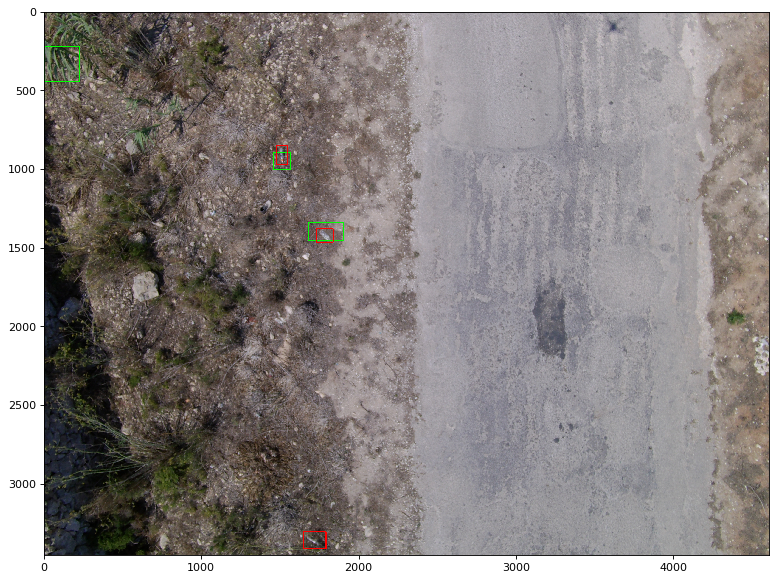

In [13]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

plt.imshow(boximage)
plt.show()

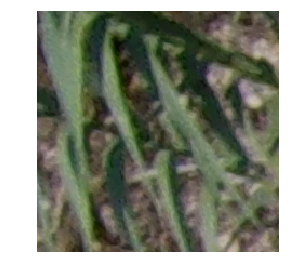

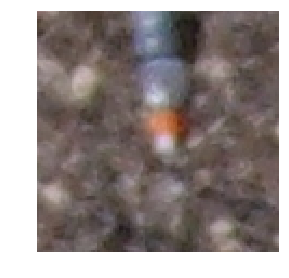

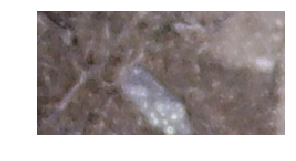

In [16]:
for i in boundingbox:
    x0,y0,x1,y1=i
    
    crop_img = image[y0:y1, x0:x1]
    figure(num=None, figsize=(4, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.axis("off")
    plt.imshow(crop_img)
    plt.show()

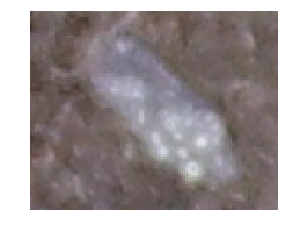

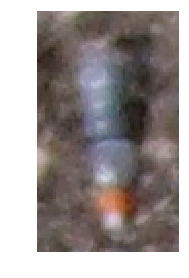

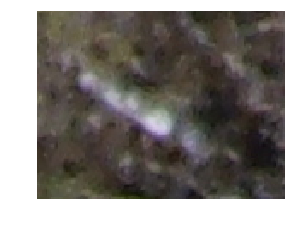

In [17]:
for i in labelbox:
    x0,y0,x1,y1=i
    
    crop_img = image[y0:y1, x0:x1]
    figure(num=None, figsize=(4, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.axis("off")
    plt.imshow(crop_img)
    plt.show()